In [3]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [4]:
# 初始化模型参数
def get_params(vocab_size,num_hiddens,device):
    # 这里的输入输出全部都是28维的one hot编码的向量,所以维度一眼都是vocab_size
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size=shape,device=device)*0.01
    
    # 相当于是输入阶段，但是此时多了个W_hh，先用x更新当前的隐藏状态h，还需要用上一个h更新当前的隐藏状态h
    W_xh = normal((num_inputs,num_hiddens))
    W_hh = normal((num_hiddens,num_hiddens))
    b_h = torch.zeros(num_hiddens,device=device)

    # 相当于是全连接层的输出
    W_hq = normal((num_hiddens,num_outputs))
    b_q = torch.zeros(num_outputs,device=device)

    params = [W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    
    return params

In [5]:
# 需要一个init_rnn_state函数在初始化时返回隐状态
 # 形状为（批量大小，隐藏单元数）

def init_rnn_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size,num_hiddens),device=device),)


In [13]:
# rnn函数定义了如何在一个时间步内计算隐状态和输出
# 前向传播函数
def rnn(inputs,state,params):
    W_xh,W_hh,b_h,W_hq,b_q = params
    H, = state
    # inputs的形状：(时间步数量，批量大小，词表大小)
    outputs = []

    # 对时间序列进行遍历
    for X in inputs:
        H = torch.tanh(torch.mm(X,W_xh)+torch.mm(H,W_hh)+b_h)
        Y = torch.mm(H,W_hq)+b_q
        outputs.append(Y)
    # 这里要保存一下H，后面要用到
    print(Y.shape)
    return torch.cat(outputs,dim=0),(H,)

In [14]:
# 创建一个类来包装这些函数
class RNNModel:
    def __init__(self,vocab_size,num_hiddens,device,get_params,init_state,forward_fn):
        self.vocab_size,self.num_hiddens = vocab_size,num_hiddens
        self.params = get_params(vocab_size,num_hiddens,device)
        self.init_state,self.forward_fn = init_state,forward_fn
    
    def __call__(self,X,state):
        X = F.one_hot(X.T,self.vocab_size).type(torch.float32)
        return self.forward_fn(X,state,self.params)
    
    def begin_state(self,batch_size,device):
        return self.init_state(batch_size,self.num_hiddens,device)

In [15]:
# 让我们检查输出是否具有正确的形状。 例如，隐状态的维数是否保持不变。
num_hiddens = 512
X = torch.arange(10).reshape((2, 5))
net = RNNModel(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

torch.Size([2, 28])


(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [16]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [17]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])


'time traveller tlclclclcl'

In [24]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [25]:
# 每轮的训练情况
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [26]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

torch.Size([32, 28])
torch.Size([1120, 28])
torch.Size([1120])
torch.Size([32, 28])
torch.Size([1120, 28])
torch.Size([1120])
torch.Size([32, 28])
torch.Size([1120, 28])
torch.Size([1120])
torch.Size([32, 28])
torch.Size([1120, 28])
torch.Size([1120])
torch.Size([32, 28])
torch.Size([1120, 28])
torch.Size([1120])
torch.Size([32, 28])
torch.Size([1120, 28])
torch.Size([1120])
torch.Size([32, 28])
torch.Size([1120, 28])
torch.Size([1120])
torch.Size([32, 28])
torch.Size([1120, 28])
torch.Size([1120])
torch.Size([32, 28])
torch.Size([1120, 28])
torch.Size([1120])
torch.Size([32, 28])
torch.Size([1120, 28])
torch.Size([1120])
torch.Size([32, 28])
torch.Size([1120, 28])
torch.Size([1120])
torch.Size([32, 28])
torch.Size([1120, 28])
torch.Size([1120])
torch.Size([32, 28])
torch.Size([1120, 28])
torch.Size([1120])
torch.Size([32, 28])
torch.Size([1120, 28])
torch.Size([1120])
torch.Size([32, 28])
torch.Size([1120, 28])
torch.Size([1120])
torch.Size([32, 28])
torch.Size([1120, 28])
torch.Size(

KeyboardInterrupt: 

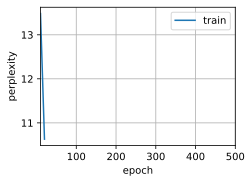

In [27]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

In [29]:
for X,Y in train_iter:
    print(X)
    print(Y)
    break

tensor([[ 3,  9,  2,  ..., 12,  1, 21],
        [ 2, 11,  1,  ..., 15,  9,  4],
        [ 1,  8,  4,  ...,  8,  3,  6],
        ...,
        [ 1,  4,  1,  ...,  2, 13,  1],
        [ 6,  3, 15,  ...,  5,  1, 13],
        [ 3,  9,  2,  ...,  9,  4,  5]])
tensor([[ 9,  2,  1,  ...,  1, 21,  2],
        [11,  1,  4,  ...,  9,  4,  5],
        [ 8,  4,  3,  ...,  3,  6,  2],
        ...,
        [ 4,  1, 15,  ..., 13,  1, 21],
        [ 3, 15, 10,  ...,  1, 13, 14],
        [ 9,  2,  1,  ...,  4,  5, 10]])
